In [5]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm import tqdm
import re
tqdm.pandas()

## Multi-modal fashion dataset
- https://huggingface.co/datasets/detection-datasets/fashionpedia

In [6]:
dataset = pd.read_csv('../../data/fashion-data/dataset.csv')
dataset = dataset.drop(columns='EncodedPixels')
data = dataset.drop_duplicates()
dataset = dataset.dropna(subset=['AttributesIds'])
len(dataset)

206410

In [7]:
dataset.head()

,ImageId,Height,Width,ClassId,AttributesIds
0,00000663ed1ff0c4e0132b9b9ac53f6e,5214,3676,6,"115,136,143,154,230,295,316,317"
1,00000663ed1ff0c4e0132b9b9ac53f6e,5214,3676,0,"115,136,142,146,225,295,316,317"
2,00000663ed1ff0c4e0132b9b9ac53f6e,5214,3676,28,163
3,00000663ed1ff0c4e0132b9b9ac53f6e,5214,3676,31,"160,204"
4,00000663ed1ff0c4e0132b9b9ac53f6e,5214,3676,32,219


In [8]:
dataset[['Height','Width']].value_counts().reset_index()

,Height,Width,count
0,3000,2000,11769
1,1500,1000,6094
2,1000,667,4857
3,3000,2001,4853
4,1024,683,4823
...,...,...,...
10802,5296,2942,1
10803,1800,1259,1
10804,1800,1318,1
10805,1601,1100,1


- different image sizes
- 206,410 data points

### Clothes labels
- hierarchy depth (e.g., level 0 = root, level 1 = supercategory, level 2 = fine-grained category)

In [9]:
with open('../../data/fashion-data/label_descriptions.json','r') as file:
    labels = json.load(file)

In [10]:
for a in labels:
    print(a)

categories
attributes


In [11]:
category_df = pd.DataFrame(labels['categories'])
attribute_df = pd.DataFrame(labels['attributes'])

In [12]:
category_df.head()

,id,name,supercategory,level
0,0,"shirt, blouse",upperbody,2
1,1,"top, t-shirt, sweatshirt",upperbody,2
2,2,sweater,upperbody,2
3,3,cardigan,upperbody,2
4,4,jacket,upperbody,2


In [13]:
for name, group in category_df.groupby('supercategory'):
    print(f"\nSupercategory: {name}")
    print(group)


Supercategory: arms and hands
    id   name   supercategory  level
17  17  glove  arms and hands      2
18  18  watch  arms and hands      2

Supercategory: closures
    id    name supercategory  level
34  34  buckle      closures      2
35  35  zipper      closures      2

Supercategory: decorations
    id      name supercategory  level
36  36  applique   decorations      2
37  37      bead   decorations      2
38  38       bow   decorations      2
39  39    flower   decorations      2
40  40    fringe   decorations      2
41  41    ribbon   decorations      2
42  42     rivet   decorations      2
43  43    ruffle   decorations      2
44  44    sequin   decorations      2
45  45    tassel   decorations      2

Supercategory: garment parts
    id       name  supercategory  level
27  27       hood  garment parts      2
28  28     collar  garment parts      2
29  29      lapel  garment parts      2
30  30  epaulette  garment parts      2
31  31     sleeve  garment parts      2
32  32   

In [14]:
attribute_df

,id,name,supercategory,level
0,0,classic (t-shirt),nickname,1
1,1,polo (shirt),nickname,1
2,2,undershirt,nickname,1
3,3,henley (shirt),nickname,1
4,4,ringer (t-shirt),nickname,1
...,...,...,...,...
289,336,peacock,animal,2
290,337,zebra,animal,2
291,338,giraffe,animal,2
292,339,toile de jouy,textile pattern,1


In [15]:
for name, group in attribute_df.groupby('supercategory'):
    print(f"\nSupercategory: {name}")
    print(group)


Supercategory: animal
      id                 name supercategory  level
286  333              leopard        animal      2
287  334  snakeskin (pattern)        animal      2
288  335              cheetah        animal      2
289  336              peacock        animal      2
290  337                zebra        animal      2
291  338              giraffe        animal      2

Supercategory: leather
      id       name supercategory  level
243  290      suede       leather      2
244  291  shearling       leather      2
245  292  crocodile       leather      2
246  293  snakeskin       leather      2

Supercategory: length
      id                     name supercategory  level
146  146   above-the-hip (length)        length      1
147  147             hip (length)        length      1
148  148           micro (length)        length      1
149  149            mini (length)        length      1
150  150  above-the-knee (length)        length      1
151  151            knee (length)     

## Add caption to the data

In [16]:
attribute_map = {x['id'] : x for x in labels['attributes']}
category_map = {x['id'] : x for x in labels['categories']}

In [17]:
images = dataset.groupby('ImageId').progress_apply(
    lambda g: [
        {
            "class_id": int(row.ClassId),
            "attr_ids": [int(x) for x in str(row.AttributesIds).split(',') if x.strip().isdigit()]
        }
        for row in g.itertuples()
    ]
).to_dict()

 99%|█████████▉| 45218/45589 [00:07<00:00, 5790.21it/s]c:\Users\Admin\Desktop\codes\fashion-recommender\fashion-env\Lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 45589/45589 [00:07<00:00, 5785.56it/s]


In [18]:
def enrich_records(records):
    enriched = []
    for r in records:
        class_name = category_map.get(r["class_id"], "unknown")
        if class_name['level'] == 2:
            attrs = [
                attribute_map.get(attr_id, f"attr_{attr_id}")['name']
                for attr_id in r["attr_ids"] if attribute_map.get(attr_id, f"attr_{attr_id}")['level'] == 1
            ]
            enriched.append({"class_name": class_name, "attributes": attrs})
    
    merged = {}
    for item in enriched:
        cls = item["class_name"]['name']
        if cls not in merged:
            merged[cls] = set()
        merged[cls].update(item["attributes"]) 
    
    return [
        {"class_name": cls, "attributes": sorted(list(attrs))} 
        for cls, attrs in merged.items()
    ]


enriched_data = {
    img_id: enrich_records(records)
    for img_id, records in images.items()
}

In [19]:
def build_target_text(records):
    lines = []
    for rec in records:
        attrs_str = ", ".join(rec["attributes"])
        lines.append(f"- {rec['class_name']}: {attrs_str}")
    return "\n".join(lines)

items = []
for img_id, records in tqdm(enriched_data.items()):
    items.append({
        "image_id": img_id,
        "input": "<image> Describe all garments and their attributes in this image.",
        "output": build_target_text(records)
    })

output = pd.DataFrame(items)

100%|██████████| 45589/45589 [00:00<00:00, 811680.74it/s]


In [20]:
output.head()

,image_id,input,output
0,00000663ed1ff0c4e0132b9b9ac53f6e,<image> Describe all garments and their attrib...,"- pants: fly (opening), low waist, maxi (lengt..."
1,0000fe7c9191fba733c8a69cfaf962b7,<image> Describe all garments and their attrib...,"- neckline: scoop (neck)\n- top, t-shirt, swea..."
2,0002ec21ddb8477e98b2cbb87ea2e269,<image> Describe all garments and their attrib...,- neckline: round (neck)\n- dress: above-the-k...
3,0002f5a0ebc162ecfb73e2c91e3b8f62,<image> Describe all garments and their attrib...,"- dress: fit and flare, floor (length), gem, g..."
4,0004467156e47b0eb6de4aa6479cbd15,<image> Describe all garments and their attrib...,"- dress: floor (length), gathering, high waist..."


In [21]:
application_data = output.sample(n=10, random_state=42)
training_data = output[~output['image_id'].isin(application_data['image_id'])]

training_data.to_parquet('../../data/vlm_data.pq')
application_data.to_parquet('../../data/user_data.pq')


## Display sample image , prompt and attribute

In [ ]:
def parse_attributes(attribute_string):
  
    if not attribute_string:
        return []
    
    result = []
    lines = attribute_string.strip().split("\n")
    
    for line in lines:
        line = line.strip()
        if not line or ':' not in line:
            continue
            
        if line.startswith('-'):
            line = line[1:].strip()
        
        category_part, attrs_part = line.split(':', 1)
        category = category_part.strip().lower()
        
        categories = [cat.strip() for cat in category.split(',')]
        
        attributes = []
        current_attr = []
        paren_depth = 0
        
        for char in attrs_part:
            if char == '(':
                paren_depth += 1
                current_attr.append(char)
            elif char == ')':
                paren_depth -= 1
                current_attr.append(char)
            elif char == ',' and paren_depth == 0:
                attr_text = ''.join(current_attr).strip()
                if attr_text:
                    attributes.append(attr_text)
                current_attr = []
            else:
                current_attr.append(char)
        
        if current_attr:
            attr_text = ''.join(current_attr).strip()
            if attr_text:
                attributes.append(attr_text)
        
        for cat in categories:
            for attr in attributes:
                if attr:  
                    attr_clean = attr.strip().lower()
                    result.append((cat, attr_clean))
    
    return result


In [24]:
sample = output.sample(n=1).iloc[0]

Prompt: <image> Describe all garments and their attributes in this image. Image: 6aa77abeca5ea2cffa50c5b715e4fe4b.jpg
Response:
- dress: above-the-knee (length), dot, fit and flare, high waist, no non-textile material, single breasted, skater (dress), symmetrical
- lapel: notched (lapel)
- sleeve: puff (sleeve), three quarter (length)
Attributes [('dress', 'above-the-knee (length)'), ('dress', 'dot'), ('dress', 'fit and flare'), ('dress', 'high waist'), ('dress', 'no non-textile material'), ('dress', 'single breasted'), ('dress', 'skater (dress)'), ('dress', 'symmetrical'), ('lapel', 'notched (lapel)'), ('sleeve', 'puff (sleeve)'), ('sleeve', 'three quarter (length)')]


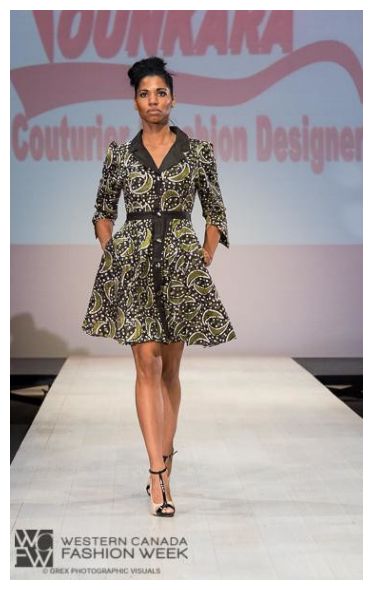

In [26]:
print(f"Prompt: {sample['input']} Image: {sample['image_id']}.jpg")
print('Response:')
print(sample['output'])
print('Attributes',parse_attributes(sample['output']))

image_path = f"../../data/fashion-data/images/{sample['image_id']}.jpg"
image = Image.open(image_path)
plt.figure(figsize=(6, 6))        
plt.imshow(image)
plt.axis('off')                  
plt.tight_layout()
plt.show()